# Exploratory study on existing early warning systems

## * Setup of the working environment *

### Import traditional Python packages

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime as dt, timedelta, date

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import time
import math
import json
import sys
import os

In [11]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [12]:
import warnings
warnings.filterwarnings('ignore')

### Import custom Python modules

In [13]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from helpers.db_connector import MySQLConnector
from helpers.db_query import *

from helpers.data_process import *
from helpers.feature_extraction import *

from extractors.akpinar_et_al import AkpinarEtAl
from extractors.boroujeni_et_al import BoroujeniEtAl
from extractors.chen_cui import ChenCui
from extractors.he_et_al import HeEtAl
from extractors.lalle_conati import LalleConati
from extractors.lemay_doleck import LemayDoleck
from extractors.mbouzao_et_al import MbouzaoEtAl
from extractors.mubarak_et_al import MubarakEtAl
from extractors.wan_et_al import WanEtAl

from helpers.ml_utils import *

from helpers.time import *

## * Load the clickstream data *

Since Fall 2017, the stream of the EPFL's Linear Algebra course has been taught in a flipped format. The implementation of the flipped classroom was carried out in an incremental manner, as described below:

- **Year 2017-2018**: traditional manner (weeks 1-13) - flipped manner (week 14).
- **Year 2018-2019**: traditional manner (weeks 1-4, 10-14) - flipped manner (weeks 5-9).
- **Year 2019-2020**: traditional manner (weeks 1-4) - flipped manner (weeks 5-14).

In [16]:
rounds = ['Y2-2018-19', 'Y3-2019-20']

### Identifying Students


The flipped course was offered only to volunteering students. The volunteers were collectively assigned into either the experimental and the control group. A stratified random sampling based on gender and the prior background (secondary educational level) of students were used.

In [17]:
%time userData = getUserInfo(prior_knowledge=True)

CPU times: user 54.2 s, sys: 2.17 s, total: 56.4 s
Wall time: 1min 13s


The initial data of volunteers was cleaned, and some participants were removed before we analyzed the data:
- The volunteering students who have not been graded were removed. 
- The repeating students were filtered out, where repeating students are those accessing videos in two different years. 
- The less active students, i.e., those who have provided less 60 interactions in the platform, were removed. 

Given that the Y1-2017-2018 round included only one week in a flipped classroom setting, we will remove the students of that round.  

In [18]:
userData = userData[userData['Round'].isin(rounds)]

Some of the statistics on the user data are provided below. 

In [19]:
"Number of students:", len(userData)

('Number of students:', 214)

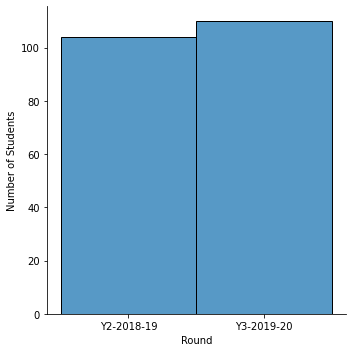

In [20]:
sns.displot(userData, x='Round')
plt.ylabel('Number of Students')
plt.show()

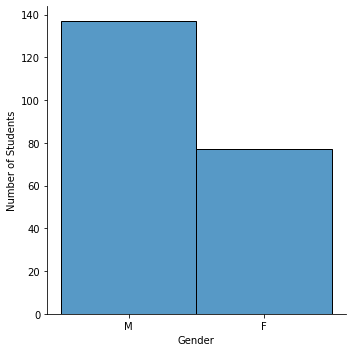

In [21]:
sns.displot(userData, x='Gender')
plt.ylabel('Number of Students')
plt.show()

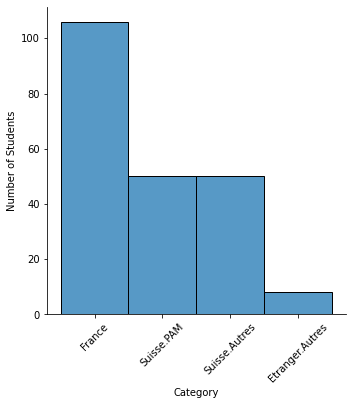

In [22]:
sns.displot(userData, x='Category')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.show()

### Getting Students' Records

#### Video Clickstream Records

In [23]:
# %time videoData = getVideoEventsInfo(mode='all')

In [24]:
# videoData = videoData[videoData['Round'].isin(rounds)]

In [25]:
# "Number of video events:", len(videoData)

#### Problem Clickstream Records

In [26]:
# %time problemData = getProblemEventsInfo()

In [27]:
# problemData = problemData[problemData['Round'].isin(rounds)]

In [28]:
# "Number of problem events:", len(problemData)

#### Exam Records

In [29]:
%time examData = getExamInfo()

CPU times: user 55.2 s, sys: 2.09 s, total: 57.3 s
Wall time: 1min 17s


In [30]:
examData = examData[examData['Round'].isin(rounds)]

In [31]:
examData = examData[examData['AccountUserID'].isin(userData['AccountUserID'])]

In [32]:
"Number of graded students:", len(examData)

('Number of graded students:', 214)

#### Event Records

In [33]:
# eventData = videoData.append(problemData)

In [34]:
# eventData['Year'] = eventData['Round'].apply(lambda x: int(x.split('-')[1]))

#### Course Week Column

We get the configuration file (e.g, start and end date) for each round of the course. 

In [35]:
# with open('../config/linear_algebra.json') as f:
#     config = json.load(f)

We assign each video interaction to a specific week of the course, with the first week of the course round having id 0. 

In [36]:
# eventData['Date'] = eventData['TimeStamp'].apply(lambda x:string2Datetime(dt.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')))

In [37]:
# tmp_events = []
# for r in rounds:
#     round_events = eventData[eventData['Round'] == r]
#     tmp_events.append(processWeek(round_events, 'Date', config[r.split('-')[-2]]['Start']))
# eventData = pd.concat(tmp_events).copy()

In [38]:
# eventData['Week'] = eventData['Week'].apply(lambda x: int(x))

Then, we filter only the first *noCourseWeeks* course weeks. 

In [39]:
# eventData = eventData[eventData['Week'].isin(range(20))]

## * Cross validation of early warning systems *

#### Parameters

In [40]:
mode = 'random'
task = 'binary'
ratio = 80
start, end, step = 5, 15, 1
iterations = 3

In [41]:
weeks = np.arange(start + 1, end, step)

#### Feature Sets

In [42]:
# featureLabels = [AkpinarEtAl(), BoroujeniEtAl(), ChenCui(), HeEtAl(), LalleConati(), LemayDoleck()]

In [43]:
featureSets = loadFeatureSets(mode, task, ratio, start, end, step)

> Found features for this experimental setting in ../data/feature_sets/feature_sets_random_binary_80_5-15-1.pkl


In [44]:
# featureSets = computeFeatures(eventData, examData, featureLabels, featureSets, start, weeks)

In [45]:
# saveFeatureSets(featureSets, mode, task, ratio, start, end, step)

In [46]:
def concat_features(featureSets):
    #Concatenate feature vectors from different papers into a single one
    features = {}
    dump_name = 'all'
    features[dump_name] = {}
    for wid in weeks:
        concat = []
        for flabel in featureSets.keys():
            concat.append(featureSets[flabel][wid])
        features[dump_name][wid] = np.hstack(concat)
    print("Number of features:",features[dump_name][wid].shape[1])
    return features

In [47]:
all_featureSets = concat_features(featureSets)

Number of features: 4157


#### Models and Metrics

In [27]:
# individuallyTrainedModels = loadTrainedModels(mode, task, ratio, start, end, step)

> Found models for this experimental setting in ../data/trained_models/trained_models_random_binary_80_5-15-1.pkl


In [48]:
lasTrainedModels = loadTrainedModels("lasso_vs_lr", task, ratio, start, end, step)

> Found models for this experimental setting in ../data/trained_models/trained_models_lasso_vs_lr_binary_80_5-15-1.pkl


In [47]:
xTrain, xTest, yTrain, yTest = getTrainTestData(examData, mode, task, ratio / 100.0)

> Binarizing student grades: [(0, 134), (1, 80)]
> Spitting the whole student population randomly: Train 171 [(0, 107), (1, 64)] - Test 43 [(0, 27), (1, 16)]


In [56]:
from tqdm import tqdm
evaluation_metrics = {
    'acc': accuracy_score,
    'f1': f1_score,
    'p': precision_score, 
    'r': recall_score,
    'tp': tp,
    'tn': tn,
    'fp': fp,
    'fn': fn
}

def fit_lasso(features, xTrain, xTest, yTrain, yTest):
    metrics = []
    coefs = []
    for wid in weeks:
        for reg in tqdm(np.linspace(0.001, 1, 5)):
            lasso = LogisticRegression(penalty='l1',solver='liblinear', C=reg)
            lasso.fit(features['all'][wid][xTrain], yTrain)
            curr = [wid, reg]
            for emid, mfunc in evaluation_metrics.items():
                val = mfunc(lasso.predict(features['all'][wid][xTest]), yTest)
                curr.append(val)
            curr.append(np.sum(abs(lasso.coef_) > 0))
            metrics.append(curr)
            coefs.append(list(lasso.coef_[0]))
            cols = ['week', 'regularization'] + list(evaluation_metrics.keys()) + ['nb_coef_used']
    return pd.DataFrame(metrics, columns=cols), coefs

In [58]:
metrics, coefs = fit_lasso(all_featureSets, xTrain, xTest, yTrain, yTest)

100%|██████████| 5/5 [00:58<00:00, 11.79s/it]


In [81]:
metrics[metrics.week == 14]

,week,regularization,acc,f1,p,r,tp,tn,fp,fn,nb_coef_used
40,14,0.00100,0.651163,0.4,0.3125,0.555556,5,23,11,4,12
41,14,0.25075,0.627907,0.5,0.5000,0.500000,8,19,8,8,71
42,14,0.50050,0.627907,0.5,0.5000,0.500000,8,19,8,8,77
43,14,0.75025,0.627907,0.5,0.5000,0.500000,8,19,8,8,85
44,14,1.00000,0.627907,0.5,0.5000,0.500000,8,19,8,8,88


In [90]:
all_featureSets.keys()

dict_keys(['all'])

In [104]:
evaluationScores = {}
for i in range(iterations):
    print('Iteration', i)
    xTrain, xTest, yTrain, yTest = getTrainTestData(examData, mode, task, ratio / 100.0)
    
    classifiersTypes = {
#                         'ada': AdaBoostClassifier(), 
#                         'dt': DecisionTreeClassifier(), 
#                         'gnb': GaussianNB(), 
                        'lr': LogisticRegression(), 
                        'las': LogisticRegression(),
#                         'mlp': MLPClassifier(), 
#                         'knn': KNeighborsClassifier(), 
#                         'rf': RandomForestClassifier(), 
#                         'svm': SVC()
                       }
    classifiersParams = {
#                          'ada': {'n_estimators': [25, 50, 100, 200], 'algorithm': ('SAMME', 'SAMME.R'), 'learning_rate': [0.1, 1]},
#                          'dt': {'criterion': ('gini', 'entropy'), 'splitter': ('best', 'random'), 'max_features': ('auto', 'sqrt', 'log2')}, 
#                          'gnb': {'var_smoothing': [1e-9, 1e-7, 1e-5, 1e-3, 1e-1]}, 
                         'lr': {'penalty': ('l2', 'elasticnet', 'none'), 'tol': [1e-4, 1e-5], 'C': [1.0, 0.5], 'solver': ('newton-cg', 'lbfgs', 'sag', 'saga'), 'multi_class': ('auto', 'ovr', 'multinomial')}, 
                         'las': {'penalty': ['l1'], 'tol': [1e-4, 1e-5],  'C': np.linspace(0.001, 2, 50), 'solver': ['liblinear']}, 
#                          'mlp': {'activation': ('identity', 'logistic', 'tanh', 'relu'), 'solver': ('lbfgs', 'sgd', 'adam'), 'hidden_layer_sizes': [(8,), (16, 8), (32, 16, 8)]},
#                          'knn': {'n_neighbors': [5, 10, 50, 100], 'weights': ('uniform', 'distance'), 'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')}, 
#                          'rf': {'n_estimators': [25, 50, 100, 200], 'criterion': ('gini', 'entropy'), 'max_features': ('auto', 'sqrt', 'log2')}, 
#                          'svm': {'C': [1.0, 0.5], 'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'gamma': ('scale', 'auto'), 'shrinking': (True, False)}
                        }
    
    trainedModels, scaler, lasso_params, lasso_coefs = trainModels(all_featureSets, xTrain, yTrain, weeks, classifiersTypes, classifiersParams, {}, lasso=True)
    
    evaluationMetrics = {'Acc': accuracy_score, 'F1': f1_score, 'P': precision_score, 'R': recall_score, 'TP': tp, 'FN': fn, 'TN': tn, 'FP': fp, 'TPR': tpr, 'TNR': tnr, 'FPR': fpr, 'FNR': fnr, 'EER': eer }
    evaluationScores = computeMetrics(scaler, all_featureSets, trainedModels, xTest, yTest, evaluationMetrics, {})
    

Iteration 0
> Binarizing student grades: [(0, 134), (1, 80)]
> Splitting the whole student population randomly: Train 171 [(0, 107), (1, 64)] - Test 43 [(0, 27), (1, 16)]
> Training on Set: all ( 001 001 ) - Week: 006 ( 001 009 ) - Algorithm: las ( 002 002 )64
> Training on Set: all ( 001 001 ) - Week: 007 ( 002 009 ) - Algorithm: las ( 002 002 )10
> Training on Set: all ( 001 001 ) - Week: 008 ( 003 009 ) - Algorithm: las ( 002 002 )54
> Training on Set: all ( 001 001 ) - Week: 009 ( 004 009 ) - Algorithm: las ( 002 002 )107
> Training on Set: all ( 001 001 ) - Week: 010 ( 005 009 ) - Algorithm: las ( 002 002 )83
> Training on Set: all ( 001 001 ) - Week: 011 ( 006 009 ) - Algorithm: las ( 002 002 )87
> Training on Set: all ( 001 001 ) - Week: 012 ( 007 009 ) - Algorithm: las ( 002 002 )87
> Training on Set: all ( 001 001 ) - Week: 013 ( 008 009 ) - Algorithm: las ( 002 002 )83
> Training on Set: all ( 001 001 ) - Week: 014 ( 009 009 ) - Algorithm: las ( 002 002 )108

> Evaluated last

In [105]:
saveTrainedModels(trainedModels, "lasso_vs_lr", task, ratio, start, end, step)

> Saved models for this experimental setting in ../data/trained_models/trained_models_lasso_vs_lr_binary_80_5-15-1.pkl


## * Show and discuss the results *

In [106]:
lst_data = []
lst_name = []
for flabel in evaluationScores.keys():
    for wid in evaluationScores[flabel].keys():
        for mid in evaluationScores[flabel][wid].keys():
            lst_data.append([wid, flabel, mid] + [np.mean(value) if i <=3 or i >=8 else np.around(np.mean(value)) for i, value in enumerate(evaluationScores[flabel][wid][mid].values())])  
            lst_name = ['week', 'set', 'clf'] + [emid for emid, _ in evaluationScores[flabel][wid][mid].items()]

In [107]:
df_results = pd.DataFrame(lst_data, columns = lst_name)

In [110]:
df_results[(df_results['week'] == 11) & (df_results['clf'] == 'las')].set_index(['week', 'set', 'clf'])

,,,Acc,F1,P,R,TP,FN,TN,FP,TPR,TNR,FPR,FNR,EER
week,set,clf,,,,,,,,,,,,,
11,all,las,0.534884,0.375,0.375,0.375,6.0,10.0,17.0,10.0,0.375,0.62963,0.37037,0.625,0.497685


In [111]:
def plot_metrics_per_model(df_results, weeks, emid, clf):

    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.title(clf)
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 8)]
    
    for i, flabel in enumerate(np.unique(df_results['set'])):    
        df_features = df_results[df_results['set'] == flabel]
        
        for j, mid in enumerate(np.unique(df_features['clf'])): 
            if mid == clf:
                df_classifiers = df_features[df_features['clf'] == mid]
                plt.plot(weeks, df_classifiers[emid].values, lw=1, color=colors[i], label=flabel)
            
    plt.ylim([0.5, 0.75])
    plt.xlim([weeks[0], weeks[-1]])
    plt.xlabel('Course week')
    plt.ylabel(emid)
    plt.grid(axis='y')
    plt.legend(loc='upper left')

In [112]:
def plot_metrics_per_feature(df_results, weeks, emid, flabel):

    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    
    df_features = df_results[df_results['set'] == flabel]

    plt.title(flabel)
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 10)]

    for j, mid in enumerate(np.unique(df_features['clf'])): 
        df_classifiers = df_features[df_features['clf'] == mid]
        plt.plot(weeks, df_classifiers[emid].values, lw=1, color=colors[j], label=mid)

    plt.axhline(y=.62, xmin=6, xmax=14, linestyle='--', color='red')    
        
    plt.ylim([0.5, 0.75])
    plt.xlim([weeks[0], weeks[-1]])
    plt.xlabel('Course week')
    plt.ylabel(emid)
    plt.grid(axis='y')
    plt.legend(loc='upper left')

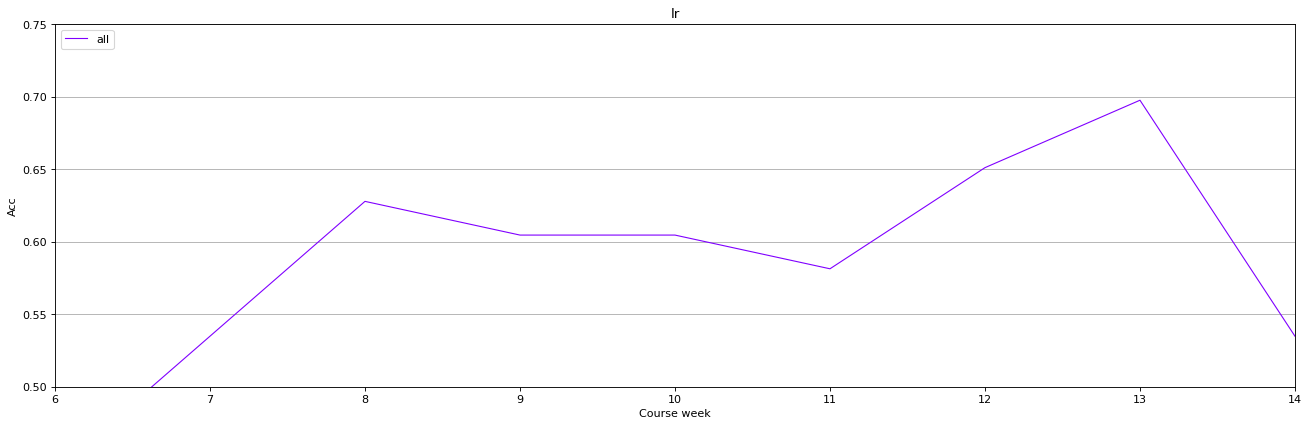

In [115]:
plot_metrics_per_model(df_results, weeks, 'Acc', 'lr')

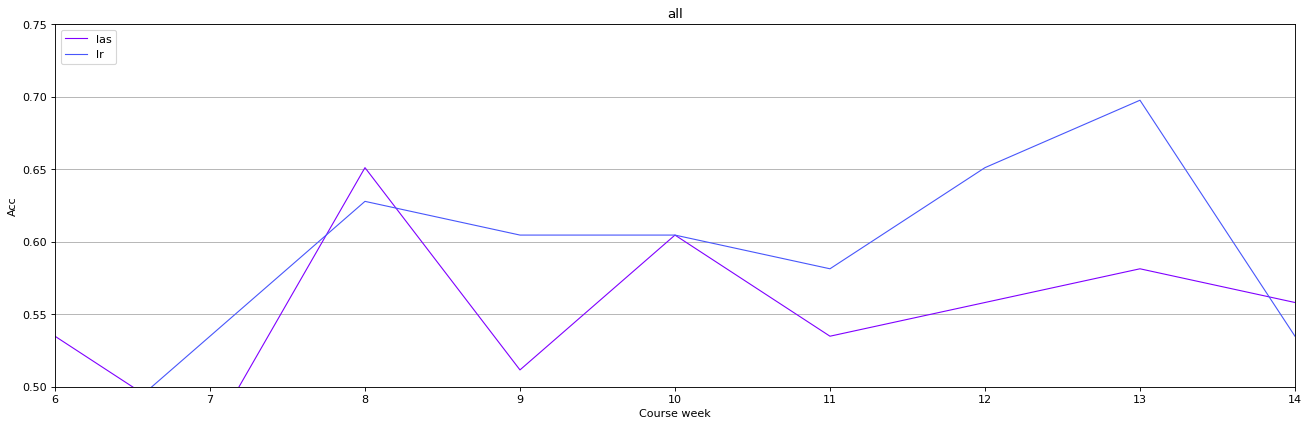

In [113]:
plot_metrics_per_feature(df_results, weeks, 'Acc', 'all')